In [175]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import rsa

## Encoding and Decoding Functions

In [176]:
def audio_from_wav(filename, save_mono=False):
    fs, data = wavfile.read(filename)
    audio = (data[:,0] + data[:,1]) // 2
    if (save_mono):
        data[:,0] = audio
        data[:,1] = audio
        filename = filename.split('.')[0] + '_mono.wav'
        wavfile.write(filename, fs, data)
    return fs, audio

def audio_to_wav(audio, filename, fs, N_original):
    data = np.zeros((N_original, 2)).astype(np.int16)
    data[:,0] = audio[0:N_original]
    data[:,1] = audio[0:N_original]
    wavfile.write(filename, fs, data)

def pad_audio(audio, fs, df):
    N = len(audio)
    N_min = fs/df
    N_req = int((N // N_min + 1) * N_min - N)
    pad = np.linspace(0, 0, N_req)
    audio = np.concatenate((audio, pad))
    return audio

def remove_low_frequencies(audio, fs, f_max):
    audio_fft = np.fft.rfft(audio)
    audio_fft[0:len(audio)*f_max//fs] = 0
    audio = np.real(np.fft.irfft(audio_fft))
    return audio

def add_data(audio, data, ampl, fs, df, f_min):
    f_min = max(f_min, df)
    
    f_data = np.linspace(f_min, f_min + (len(data)-1) * df, len(data))
    f_audio = np.fft.rfftfreq(len(audio), 1/fs)
    audio_fft = np.fft.rfft(audio)

    f_d = 0
    for f in range(len(f_audio)):
        if (f_data[f_d] <= f_audio[f]):
            audio_fft[f] = ampl * data[f_d]
            f_d += 1
            if f_d == len(f_data):
                break

    audio = np.real(np.fft.irfft(audio_fft))
    return audio

def recover_data(audio, data_ampl, data_len, fs, df, f_min):
    data = np.zeros(data_len)

    f_data = np.linspace(f_min, f_min + (len(data)-1) * df, len(data))
    f_audio = np.fft.rfftfreq(len(audio), 1/fs)
    audio_fft = np.fft.rfft(audio)

    f_d = 0
    for f in range(len(f_audio)):
        if (f_data[f_d] <= f_audio[f]):
            if (audio_fft[f] > data_ampl/2):
                data[f_d] = 1
            f_d += 1
            if f_d == len(f_data):
                break
    return data

## Encryption Functions

In [177]:
def create_keys(length):
    public_key, private_key = rsa.newkeys(length)

    with open('public_key.pem', 'wb') as f:
        f.write(public_key.save_pkcs1())
    
    with open('private_key.pem', 'wb') as f:
        f.write(private_key.save_pkcs1())
        
    return public_key, private_key

def encrypt_data(message, private_key):
    return rsa.sign(message.encode(), private_key, 'SHA-1')

def check_data(message, sign_message , public_key):
    try:
        rsa.verify(message.encode(), sign_message, public_key)
        return True
    except:
        return False
    

def extract_audio_signature(audio_name):
    fs, audio = audio_from_wav(audio_name)

    # start inputs
    f_start = 100
    f_end = 4100
    df = 1
    section_size = 100

    # arrays
    averages = np.zeros((f_end-f_start)//section_size)
    byte_averages = np.zeros(len(averages)//8)
    output = np.zeros(len(averages))

    # fourier transform audio
    audio = pad_audio(audio, fs, df)
    f_full = np.fft.rfftfreq(len(audio), 1/fs)
    audio_fft = np.fft.rfft(audio)

    # calculate average for all
    total, count = 0, 0
    section = 0
    section_start = f_start + section * section_size
    section_end = section_start + section_size
    for i in range(len(f_full)):
        if (f_full[i] > section_start and f_full[i] <= section_end):
            total += np.abs(audio_fft[i])
            count+=1

        if (f_full[i] >= section_end):
            averages[section] = total / count
            count = 0
            total = 0

            section += 1
            section_start = f_start + section * section_size
            section_end = section_start + section_size

            if (section == len(averages)):
                break



    # calculate count ave for each byte
    for i in range(len(averages)):
        byte_averages[i//8] += averages[i]
    byte_averages = byte_averages / 8

    # compare averages
    for i in range(len(averages)):
        output[i] = (averages[i] > byte_averages[i//8])

    return output.astype(int)


def convert_bit_array_to_string(bit_array):
    print(type(bit_array[0]))
    binary_string = ''.join(str(bit) for bit in bit_array)
    ascii_chars = ["0" + binary_string[i+1:i+8] for i in range(0, len(binary_string), 8)]
    print(ascii_chars)
    string = ''.join(chr(int(char, 2)) for char in ascii_chars)
    return string

def bytes_to_binary(bytes_obj):
    return ''.join(format(byte, '08b') for byte in bytes_obj)

def binary_to_bytes(binary_str):
    return bytes(int(binary_str[i:i+8], 2) for i in range(0, len(binary_str), 8))


def get_data(audio_name,private_key):
    message = convert_bit_array_to_string(extract_audio_signature(audio_name))

    sign_message = encrypt_data(message, private_key)
    bin_sign_message=bytes_to_binary(sign_message)    
    bin_data = [int(bit) for bit in bin_sign_message]
    return bin_data


def check_watermark(audio_name, bin_data_array , public_key):
    message = convert_bit_array_to_string(extract_audio_signature(audio_name))
    bin_data = ''.join(str(bit) for bit in bin_data_array)
    sign_message = binary_to_bytes(bin_data)
    return check_data(message, sign_message, public_key)
    
public_key, private_key = create_keys(365)

watermark = get_data('AudioFiles/bumblebee/bumblebee_small.wav',private_key)

print(len(watermark))

print(check_watermark('AudioFiles/bumblebee/bumblebee_small_with_data.wav', watermark, public_key))


<class 'numpy.int32'>
['01101000', '01001000', '01100100', '01110000', '00000001']
368
<class 'numpy.int32'>
['01101000', '00001000', '01100100', '01010000', '01000001']
False


## Helper Functions

In [178]:
def plot_fft(audio, fs, f_max = 250):
    f_full = np.fft.rfftfreq(len(audio), 1/fs)
    audio_fft = np.fft.rfft(audio)
    plt.figure()
    plt.plot(f_full, np.abs(audio_fft))
    plt.xlim([0, f_max])
    plt.ylim([0, 1.5e7])
    plt.title('Song fft')

## Implentation

In [179]:
DELTA_FREQUENCIES = 0.2 # Hz
LOWEST_FREQUENCY = 1 # Hz
DATA_LENGTH = 368
BINARY_AMPLITUDES = 1e7

def encrypt_audio(filename):
    # Keys and data
    public_key, private_key = create_keys(365);
    data = get_data(filename, private_key)
    print(data)
    print(''.join(str(bit) for bit in data))
    # Audio from file
    fs, audio = audio_from_wav(filename, True)
    N_original = len(audio)
    # plot_fft(audio, fs)

    # Add data to audio
    audio = pad_audio(audio, fs, DELTA_FREQUENCIES)
    audio = remove_low_frequencies(audio, fs, 100)
    # plot_fft(audio, fs)
    audio = add_data(audio, data, BINARY_AMPLITUDES, fs, DELTA_FREQUENCIES, LOWEST_FREQUENCY)
    # plot_fft(audio, fs)
    plot_fft(audio, fs)

    # Save audio to file
    audio_to_wav(audio, filename.split('.')[0] + '_with_data.wav', fs, N_original)
    return public_key, private_key

    

def check_audio(filename, public_key):
    fs, audio = audio_from_wav(filename)
    audio = pad_audio(audio, fs, DELTA_FREQUENCIES)
    plot_fft(audio, fs)

    data_r = recover_data(audio, BINARY_AMPLITUDES, DATA_LENGTH, fs, DELTA_FREQUENCIES, LOWEST_FREQUENCY).astype(int)
    
    #print(data_r)
    print(''.join(str(bit) for bit in data_r))

    check = check_watermark(filename,data_r,public_key)
    return check


<class 'numpy.int32'>
['01101000', '01001000', '01100100', '01110000', '00000001']
[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0

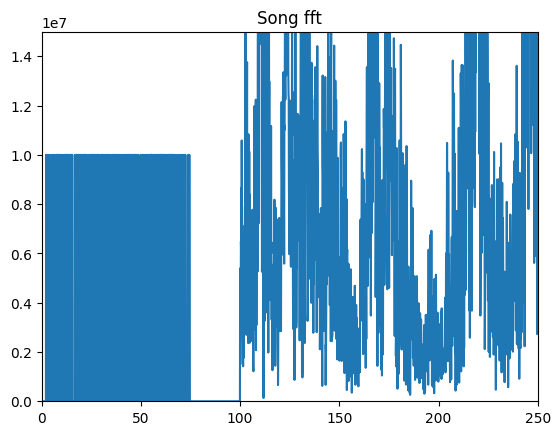

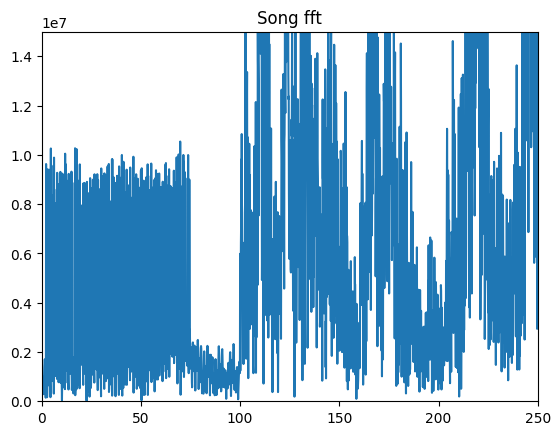

In [180]:
public_key, _ = encrypt_audio('AudioFiles/bumblebee/bumblebee_small.wav')
print(check_audio('AudioFiles/bumblebee/bumblebee_small_with_data.wav', public_key))


In [181]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def extract_potential_code_segments(y, sr, lowcut=100, highcut=41000):
  """
  Extracts potential code segments from an audio signal using spectral features.

  Args:
      y (np.ndarray): Audio signal data.
      sr (int): Sampling rate of the audio signal.
      lowcut (int, optional): Lower cutoff frequency for filtering (Hz). Defaults to 100.
      highcut (int, optional): Higher cutoff frequency for filtering (Hz). Defaults to 46000.

  Returns:
      list: List of potential code segments (time windows).
  """

  # Apply bandpass filter (optional, adjust parameters as needed)
  from scipy.signal import butter, lfilter
  b, a = butter_bandpass(lowcut, highcut, sr, order=5)
  y_filtered = lfilter(b, a, y)

  # Extract features (consider experimenting with different feature sets)
  melspectrogram = librosa.feature.melspectrogram(y=y_filtered, sr=sr, n_mels=128)
  mfccs = librosa.feature.mfcc(y=y_filtered, sr=sr, n_mfcc=20)

  # Combine features (optional)
  features = np.vstack([melspectrogram.flatten(), mfccs.flatten()])

  # Anomaly detection using K-Means clustering
  kmeans = KMeans(n_clusters=2, random_state=0)
  kmeans.fit(features.T)
  labels = kmeans.labels_

  # Identify potential code segments based on cluster membership
  potential_code_segments = []
  window_size = 0.5  # Adjust window size as needed (in seconds)
  for i in range(len(labels)):
    if labels[i] == 1:  # Adjust cluster index based on anomaly detection results
      start_time = i * window_size / sr
      end_time = start_time + window_size
      potential_code_segments.append((start_time, end_time))

  return potential_code_segments

def visualize_features(y, sr, segments):
  """
  Visualizes melspectrogram and potential code segments for analysis.

  Args:
      y (np.ndarray): Audio signal data.
      sr (int): Sampling rate of the audio signal.
      segments (list): List of potential code segments (time windows).
  """

  melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
  plt.figure(figsize=(12, 4))
  librosa.display.specshow(melspectrogram, sr=sr, x_axis='time', y_axis='mel')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Mel-frequency spectrogram')
  plt.xlabel('Time (s)')
  plt.ylabel('Mel frequency')

  for start_time, end_time in segments:
    plt.axvspan(start_time, end_time, alpha=0.2, color='red', label='Potential code segment')
  plt.legend()
  plt.tight_layout()
  plt.show()

# Load your audio file
y, sr = librosa.load("bumblebee_small.wav")

# Extract potential code segments
potential_code_segments = extract_potential_code_segments(y, sr)

# Visualize features for analysis (optional)
visualize_features(y, sr, potential_code_segments)

# Further analysis (consider additional processing based on code embedding method)
#   - For frequency modulation: demodulation to extract the embedded signal
#   - For spread spectrum techniques: correlation analysis in the frequency domain
#   - For machine learning: train a model to classify/decode the code segments

print("Extracted potential code segments:", potential_code_segments)

# Important note: This approach provides a starting point for identifying potentially encoded segments. 
# The actual decoding process depends heavily on the specific encoding method used.

ModuleNotFoundError: No module named 'librosa'